In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from LoraHelpers import convert_model_to_lora_model, change_lora_alpha
from data_loader import load_dataset_from_list, load_json_data
from tqdm.notebook import tqdm
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

model_path = "./llama-3.2-1b-inst"

In [2]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)
convert_model_to_lora_model(model)
change_lora_alpha(model, 0.125)

In [3]:
Crterion = CrossEntropyLoss(reduction="mean")
optimizer = AdamW(model.parameters(), lr=1e-4)

In [4]:
data_samples = load_json_data()
data = load_dataset_from_list(data_samples)

In [5]:
a = model.forward(torch.tensor(data[0]["input_tokens"]).unsqueeze(0)).logits
# a = torch.softmax(a, dim=-1)
a = a.softmax(dim=-1)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [6]:
a.shape, torch.tensor(data[0]["output_tokens"]).unsqueeze(0).shape, data[0]["sep_token_index"]

(torch.Size([1, 49, 128256]), torch.Size([1, 49]), 10)

In [7]:
torch.tensor(data[0]["output_tokens"])

tensor([  3513,   6261,     26,   5127,    775,    374,   2736,   4529,     13,
           765,   9681,     25,   2570,   1395,  53246,    726,    518,    364,
         61887,   9339,  17453,  78342,    518,    364,     71,  36224,     88,
           518,    364,   1354,   5682,   1697,    518,    364,  34965,  45213,
          2844,  83528,   7063,   2695,  35376,    518,    364,   3022,   3502,
          7164,  58182,    663, 128009])

In [8]:
Crterion(a.squeeze()[10:], torch.tensor(data[0]["output_tokens"][10:]))

tensor(11.3790, grad_fn=<NllLossBackward0>)

In [9]:
tokenizer.decode(a.argmax(dim=-1)[0])

"#ach, be else is already taken.\n - Unknown: selfself yourselfself','selfgames okins','selfappinessy', 'authpirationational','motunderuted',car-wil','self',spiror']\n\n |\n"

In [ ]:
train_losses = []

In [ ]:
epochs = 5
for epoch in tqdm(range(epochs)):
    pbar = tqdm(range(len(data)), leave=False)
    for i in pbar:
        optimizer.zero_grad()
        mask_idx = data[i]["sep_token_index"]
        outs = model.forward(torch.tensor(data[i]['input_tokens']).unsqueeze(0)).logits.softmax(dim=-1)
        sample_loss = Crterion(outs.squeeze()[mask_idx:], torch.tensor(data[i]["output_tokens"][mask_idx:]))
        train_losses.append(sample_loss.detach())
        sample_loss.backward()
        optimizer.step()
        del outs
        del sample_loss
        pbar.set_description("" if len(train_losses)==0 else f"loss : {train_losses[-1]:.3f}")
    change_lora_alpha(model, 0.125*2**epoch)

In [42]:
train_losses_bkp = [float(item) for item in train_losses]
#train_losses_bkp

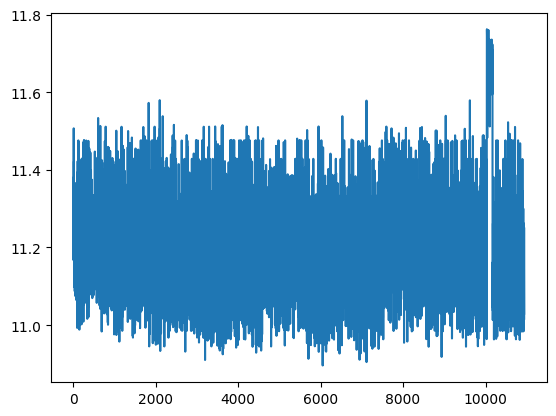

In [43]:
import matplotlib.pyplot as plt
plt.plot(train_losses_bkp)
plt.show()

In [54]:
change_lora_alpha(model, 0.5)

In [56]:
s = tokenizer("Mischief managed | tags:", return_tensors='pt')['input_ids']
a = model.generate(s, max_new_tokens=200)
print("".join([tokenizer.decode(token) for token in a[0]]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Mischief managed | tags: mischief']<|eot_id|>


In [57]:
s = tokenizer("Don't cry because its over, smile because it happened | tags:", return_tensors='pt')['input_ids']
a = model.generate(s, max_new_tokens=200)
print("".join([tokenizer.decode(token) for token in a[0]]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Don't cry because its over, smile because it happened | tags:', 'humor', 'smile']<|eot_id|>


In [65]:
s = tokenizer("row, row, row, your boat. | tags:", return_tensors='pt')['input_ids']
a = model.generate(s, max_new_tokens=20)
print("".join([tokenizer.decode(token) for token in a[0]]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>row, row, row, your boat. | tags::humor', 'rows', 'row', 'rows', 'rows', 'rows', '


In [66]:
change_lora_alpha(model, 0.)

In [67]:
s = tokenizer("Mischief managed | tags:", return_tensors='pt')['input_ids']
a = model.generate(s, max_new_tokens=20)
print("".join([tokenizer.decode(token) for token in a[0]]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Mischief managed | tags: fiction, fantasy, character development, relationships

It's been a while since I've had a chance


In [71]:
s = tokenizer("Don't cry because its over, smile because it happened | tags:", return_tensors='pt')['input_ids']
a = model.generate(s, max_new_tokens=20)
print("".join([tokenizer.decode(token) for token in a[0]]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Don't cry because its over, smile because it happened | tags: #relaxation, #selfcare, #mentalhealthmatters, #mindfulness, #


In [69]:
s = tokenizer("row row row your boat | tags:", return_tensors='pt')['input_ids']
a = model.generate(s, max_new_tokens=20)
print("".join([tokenizer.decode(token) for token in a[0]]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>row row row your boat | tags: poetry, boat, rowing, rowing poem

The classic nursery rhyme "Row, Row,


In [81]:
import pickle
with open("lora_model.pkl", 'wb') as f:
    pickle.dump(model, f)

In [82]:
with open("lora_model.pkl", 'rb') as f:
    tmp_model = pickle.load(f)

In [84]:
change_lora_alpha(tmp_model, 0.5)

In [100]:
s = tokenizer("Thank God it's Friday | tags:", return_tensors='pt')['input_ids']
a = tmp_model.generate(s, max_new_tokens=20)
print("".join([tokenizer.decode(token) for token in a[0]]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Thank God it's Friday | tags: friday', 'god', 'humor', 'weekends']<|eot_id|>


In [101]:
del tmp_model